In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os
from joblib import Parallel, delayed

lmap = lambda func, *iterable: list(map(func, *iterable))

In [4]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"])
mpl.colormaps.register(cmap)

In [5]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [6]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [7]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1])))
df_meta.Robust = df_meta.Robust.apply(bool)

In [8]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)

In [9]:
def ortho_cond(W):
    n = W.shape[0]
    t = np.expand_dims(np.linalg.norm(W, axis=1), axis=1)
    t[t == 0] = 1
    W = W / t
    c = np.abs(W.dot(W.T) - np.eye(n)).sum() / (n*(n-1))
    return 1 - c

In [10]:
ortho = Parallel(n_jobs=-1, verbose=100)(delayed(ortho_cond)(dX[ids].reshape(n, -1)) for ids, n in tqdm(zip(df_meta.reset_index().filter_ids, df_meta.reset_index().out_channels)))

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [11]:
df_meta["ortho"] = ortho

In [12]:
df_meta[["ortho"]].to_hdf(dataset_path, "meta_ortho")

In [13]:
def agg_by_depth_decile(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({'result': (s["ortho"] * s["out_channels"]).sum() / s["out_channels"].sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

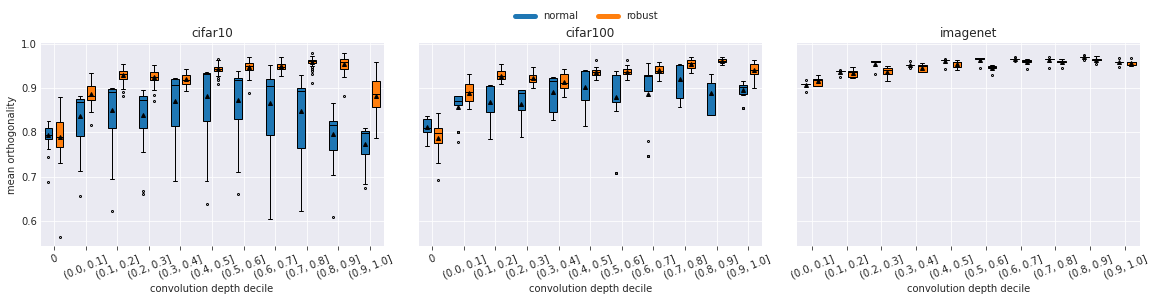

In [14]:
from boxplots import boxplots

with plt.style.context("seaborn-dark"):
    plt.rcParams['xtick.major.size'] = 3.5
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), facecolor="white", sharey=True)

    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0])
    axes[0].set_title("cifar10")

    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1])
    axes[1].set_title("cifar100")


    boxplots(
        [
            agg_by_depth_decile(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2])
    axes[2].set_title("imagenet")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0.05, 1, 1), ncol=3)
    fig.tight_layout()
    axes[0].set_ylabel("mean orthogonality")
    plt.savefig("plots/orthogonality_normal_vs_robust.pdf", bbox_inches='tight')